In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
from __future__ import division
import pymc3 as pm3
import statsmodels.formula.api as smf
from sklearn import cluster, preprocessing

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The data for this project is a set of california housing data from the 1990 census. Each observation represents a census block, of which there are 20606 in total. From each census block the longitude, latitude, median age, total rooms across all households, total bedrooms across all households, populatin, number of households, median income, and median house value were collected. The goal is to look at factors affecting the median house value. 

In [2]:
data = pd.read_csv("CAHouse.csv",header = 0,low_memory=False)

In [3]:
data.columns = ['long','lat','medage','rooms','bed','popu','houses','medinc','medhv']

In [4]:
# Create average number of rooms and bedrooms per home. These variables will be used in lieu of
# the original room and bedrooom variables

data['avgrooms'] = data.rooms/data.houses
data['avgbed'] = data.bed/data.houses

In [5]:
data.head()

,long,lat,medage,rooms,bed,popu,houses,medinc,medhv,avgrooms,avgbed
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,6.984127,1.023810
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,6.238137,0.971880
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100,8.288136,1.073446
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300,5.817352,1.073059
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200,6.281853,1.081081


In [6]:
data.corr()

,long,lat,medage,rooms,bed,popu,houses,medinc,medhv,avgrooms,avgbed
long,1.000000,-0.924588,-0.108448,0.045377,0.069696,0.100457,0.056531,-0.014659,-0.044433,-0.028103,0.013267
lat,-0.924588,1.000000,0.011201,-0.036688,-0.067303,-0.109304,-0.071987,-0.080356,-0.145703,0.106885,0.069875
medage,-0.108448,0.011201,1.000000,-0.361433,-0.320554,-0.296511,-0.302939,-0.118811,0.105106,-0.153571,-0.077884
rooms,0.045377,-0.036688,-0.361433,1.000000,0.929972,0.857050,0.918483,0.198044,0.133745,0.133846,0.029440
bed,0.069696,-0.067303,-0.320554,0.929972,1.000000,0.878298,0.979787,-0.008319,0.049954,0.000964,0.045921
popu,0.100457,-0.109304,-0.296511,0.857050,0.878298,1.000000,0.907471,0.004897,-0.025143,-0.072432,-0.066310
houses,0.056531,-0.071987,-0.302939,0.918483,0.979787,0.907471,1.000000,0.012864,0.065301,-0.080565,-0.055016
medinc,-0.014659,-0.080356,-0.118811,0.198044,-0.008319,0.004897,0.012864,1.000000,0.688714,0.326966,-0.062077
medhv,-0.044433,-0.145703,0.105106,0.133745,0.049954,-0.025143,0.065301,0.688714,1.000000,0.152030,-0.047020
avgrooms,-0.028103,0.106885,-0.153571,0.133846,0.000964,-0.072432,-0.080565,0.326966,0.152030,1.000000,0.847768


The correlation table has one notable feature. As one might expect the average number of rooms and average number of bedrooms in a census block are highly correlated. This is will become important later as this correlation will affect sampling.

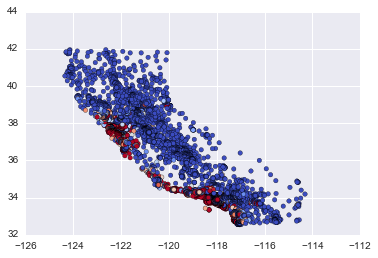

In [92]:
colors = plt.cm.coolwarm((data.medhv-data.medhv.mean())/data.medhv.std())
plt.scatter(x=data.long,y=data.lat,c=colors)

plt.show()

The plot above displays all of the census blocks in the data set. They are plotted by their longitude and latitude values, producing a map of California. The points are colored by the median home value in that census block, with deep blues having the lowest value and deep reds having the highest values. As expected, census blocks near Los Angeles, San Diego, the Bay Area, as well as those generally along the coast tend to have higher median home values while those inland and in the northern part of the state have lower home values.  

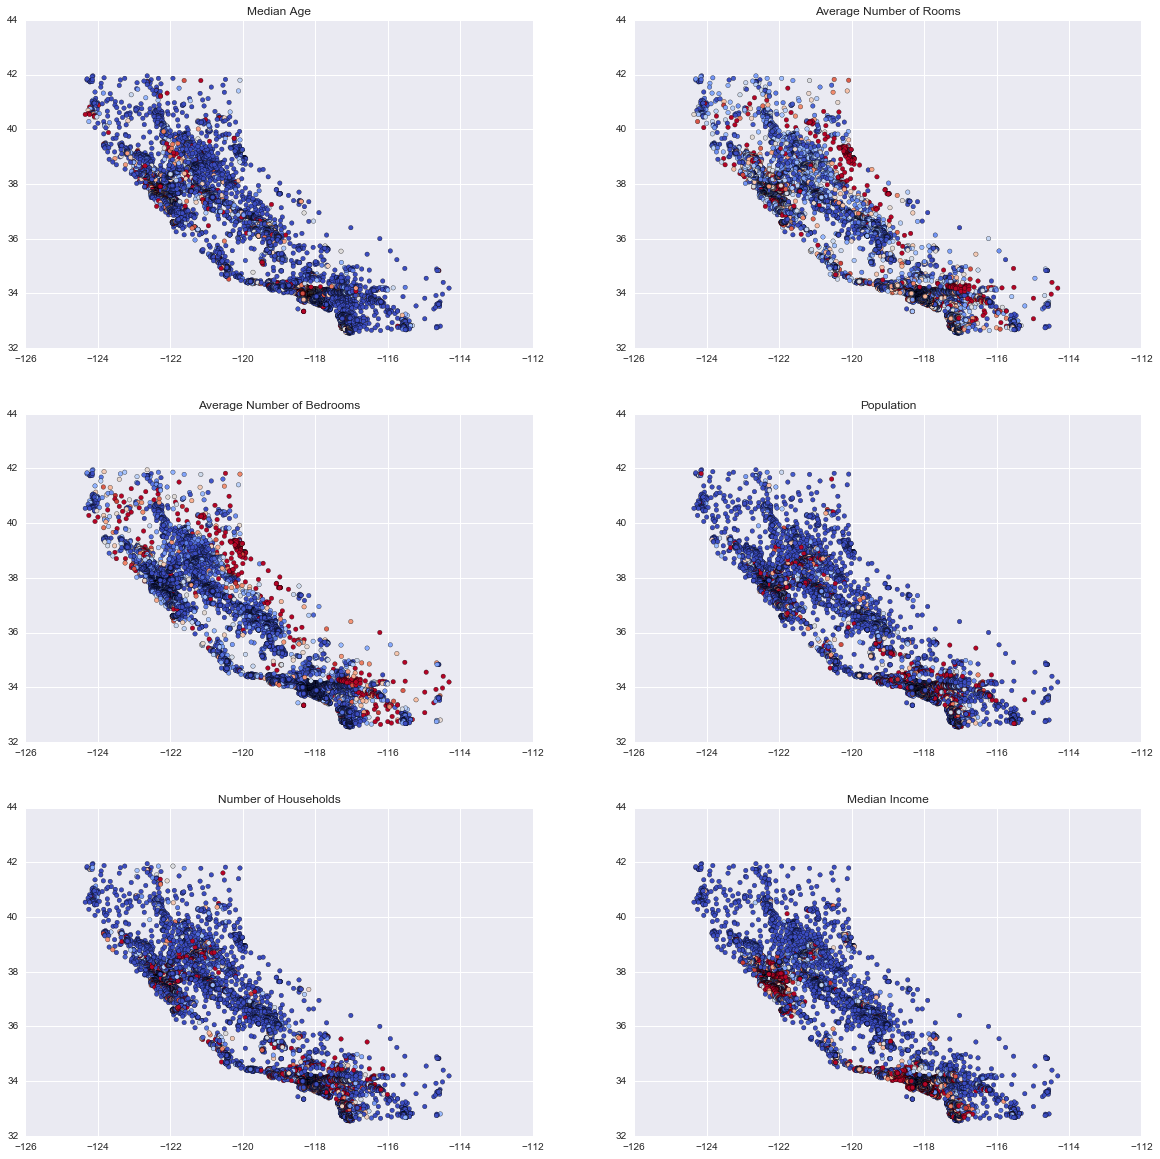

In [165]:
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
colors1 = plt.cm.coolwarm((data.medage-data.medage.mean())/data.medage.std())
plt.scatter(x=data.long,y=data.lat,c=colors1)
plt.title("Median Age")

plt.subplot(3,2,2)
colors2 = plt.cm.coolwarm((data.avgrooms-data.avgrooms.mean())/data.avgrooms.std())
plt.scatter(x=data.long,y=data.lat,c=colors2)
plt.title("Average Number of Rooms")

plt.subplot(3,2,3)
colors3 = plt.cm.coolwarm((data.avgbed-data.avgbed.mean())/data.avgbed.std())
plt.scatter(x=data.long,y=data.lat,c=colors3)
plt.title("Average Number of Bedrooms")

plt.subplot(3,2,4)
colors4 = plt.cm.coolwarm((data.popu-data.popu.mean())/data.popu.std())
plt.scatter(x=data.long,y=data.lat,c=colors4)
plt.title("Population")

plt.subplot(3,2,5)
colors5 = plt.cm.coolwarm((data.houses-data.houses.mean())/data.houses.std())
plt.scatter(x=data.long,y=data.lat,c=colors5)
plt.title("Number of Households")

plt.subplot(3,2,6)
colors6 = plt.cm.coolwarm((data.medinc-data.medinc.mean())/data.medinc.std())
plt.scatter(x=data.long,y=data.lat,c=colors6)
plt.title("Median Income")

plt.show()

The plots show a similar map but are instead colored by the predictor named in the title. Again, blues represent lower values and reds represent higher values. These can help us pick out some of the correlations we expect to see in the data. For example areas with high median income also appear to generally have higher median home values. This is not surprising. More surprising is that the areas near Los Angeles, San Diego, and the Bay Area seem to have fewer bedrooms per household but have higher median home values.

In [7]:
centroid,label,inertia = cluster.k_means(n_clusters=5, X = data.loc[:,["long","lat"]])

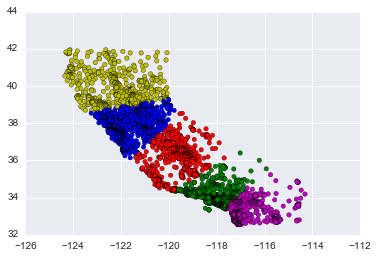

In [151]:
colors = []
for i in range(len(data.long)):
    if label[i] == 0:
        colors.append("r")
    elif label[i] == 1:
        colors.append("g")
    elif label[i] == 2:
        colors.append("b")
    elif label[i] == 3:
        colors.append("y")
    elif label[i] == 4:
        colors.append("m")
    elif label[i] == 5:
        colors.append("c")
    
plt.scatter(x=data.long,y=data.lat,c=colors)

plt.show()

Looking at the plots of median house value (as well as some of the predictors), there appears to be strong regional trends. This suggests that these regions will need to be brough into the model through a hierarchical structure. The map above shows the data points after k-means clustering based on longitude and latitude values. The number of clusters was chosen by looking at elbows in the inertia values.

Before a hierarchical structure is implemented we will look at the model with no hierarchy.

In [8]:
mod1 = pm3.Model()

with mod1:
    # Non-Hierarchical Parameters
    intercept = pm3.Flat('Intercept')
    medage = pm3.Flat('medage')
    avgrooms = pm3.Flat('avgrooms')
    avgbed = pm3.Flat('avgbed')
    popu = pm3.Flat('popu')
    houses = pm3.Flat('houses')
    medinc = pm3.Flat('medinc')
    sigma = pm3.HalfNormal('Sigma',sd = 20)
    
    mu = intercept + medage*data.medage + avgrooms*data.avgrooms + avgbed*data.avgbed +\
       popu*data.popu + houses*data.houses + medinc*data.medinc\
            
        
    like = pm3.Normal('Likelihood',mu=mu,sd=sigma,observed=data.medhv)

Applied log-transform to Sigma and added transformed Sigma_log to model.


In [9]:
with mod1:
    step = pm3.NUTS()
    trace_model = pm3.sample(5000, step)

 [-----------------100%-----------------] 5000 of 5000 complete in 259.2 sec

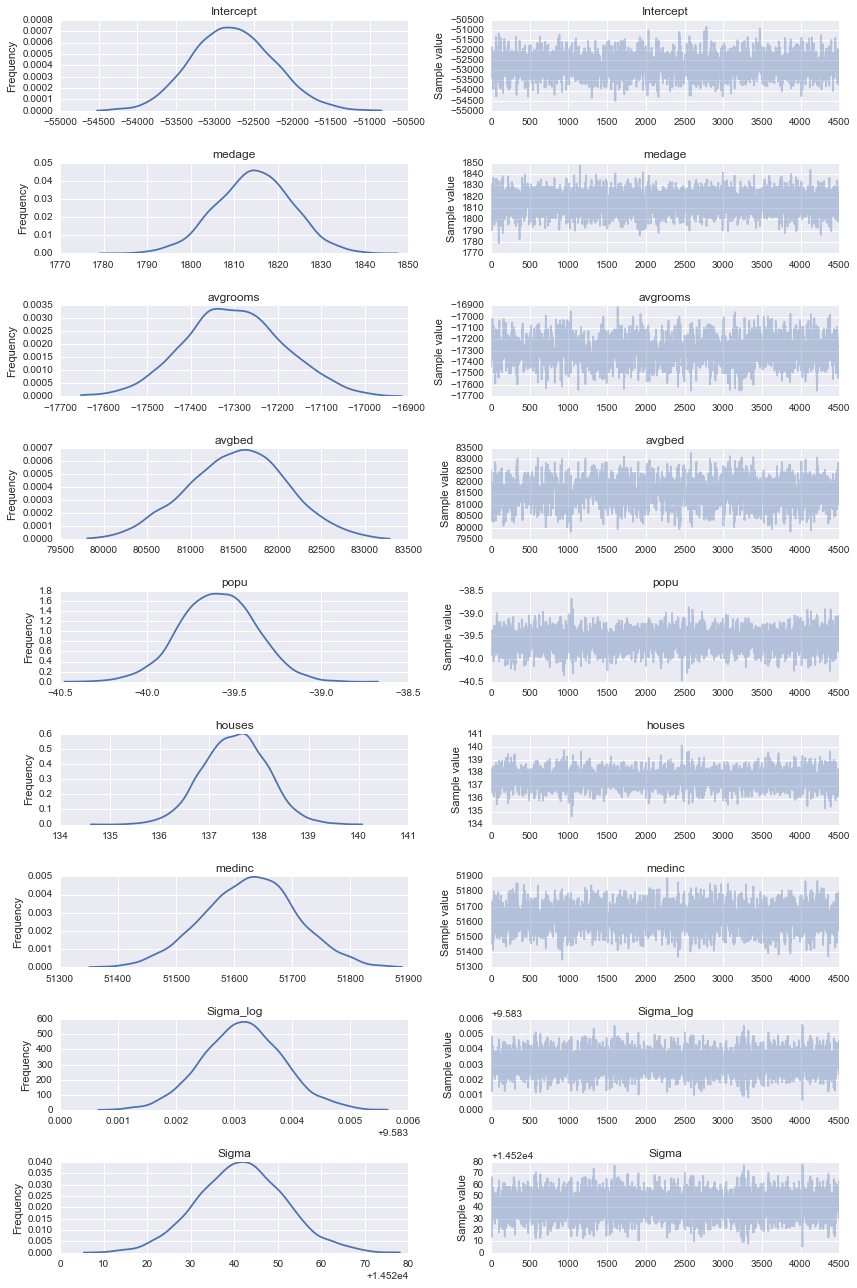

In [112]:
pm3.traceplot(trace_model[500:]);

In [ ]:
scores = pm3.geweke(trace_model[500:])
varnames = scores.keys()
varnames.remove('sigma_log') #sigma_log is nuisance variable, ignore
chainids = scores.keys()
colors_for_chains = ['g']

plt.figure(figsize=(10,15))
plt.subplots_adjust(top=0.85)
plt.suptitle('Geweke Plot',fontsize=25)

plotnum = 1
for i in varnames:
    plt.subplot(len(varnames),1,plotnum)
    plt.title(i)
    for j in chainids:
        plt.scatter(scores[j][i][:,0],scores[j][i][:,1],s=50,c=colors_for_chains[j])
 
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.xlim(-50,4050)
    plotnum+=1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])


All of the plots appear to show convergence so we shall proceed.

In [10]:
regions = len(np.unique(label))

In [116]:
smf.ols('medhv~medage+avgrooms+avgbed+popu+houses+medinc',data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  medhv   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     4624.
Date:                Mon, 09 May 2016   Prob (F-statistic):               0.00
Time:                        17:44:29   Log-Likelihood:            -2.6062e+05
No. Observations:               20606   AIC:                         5.213e+05
Df Residuals:                   20599   BIC:                         5.213e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -5.277e+04   2663.075    -19.816      0.000      -5.8e+04 -4.76e+04
medage      1814.5090     44.868     40.441      0.000      1726.564  1902.454
avgrooms    -1.73e+04    586.027    -29.525      0.000     -1.85e+04 -1.62e+04
avgbed      8.156e+04   2873.021     28.387      0.000      7.59e+04  8.72e+04
popu         -39.5951      1.112    -35.607      0.000       -41.775   -37.415
houses       137.5185      3.321     41.410      0.000       131.009   144.028
medinc      5.163e+04    399.988    129.077      0.000      5.08e+04  5.24e+04
==============================================================================
Omnibus:                     4644.320   Durbin-Watson:                   1.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19768.749
Skew:                           1.053   Prob(JB):                         0.00
Kurtosis:                       7.312   Cond. No.                     1.22e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The OLS results will be used to determine the parameters for the parent variables in the hierarchy. As noted previously, the hierarchy is based on the observations region.

In [167]:
hier_model_regions = pm3.Model()

with hier_model_regions:
    # hierarchical parent variables
    mu_medage = pm3.Normal('medage Mean',mu = 1814.5090, sd=44.868)
    sigma_medage = pm3.HalfNormal('medage Sigma',sd = 20)
    mu_intercept = pm3.Normal('Intercept Mean',mu = -5.277e+04, sd=2663.075)
    sigma_intercept = pm3.HalfNormal('Intercept Sigma',sd = 20)
    mu_avgrooms = pm3.Normal('avgrooms Mean',mu = -1.73e+04, sd=586.027)
    sigma_avgrooms = pm3.HalfNormal('avgrooms Sigma',sd = 20)
    mu_avgbed = pm3.Normal('avgbed Mean',mu = 8.156e+048, sd=2873.021)
    sigma_avgbed = pm3.HalfNormal('avgbed Sigma',sd = 20)
    mu_popu = pm3.Normal('popu Mean',mu = -39.5951, sd=1.112)
    sigma_popu = pm3.HalfNormal('popu Sigma',sd = 20)
    mu_houses = pm3.Normal('houses Mean',mu = 137.5185, sd=3.321)
    sigma_houses = pm3.HalfNormal('houses Sigma',sd = 20)
    mu_medinc = pm3.Normal('medinc Mean',mu = 5.163e+04, sd=399.988)
    sigma_medinc = pm3.HalfNormal('medinc Sigma',sd = 20)
    
    # Non-Hierarchical Parameters
    medage = pm3.Normal('medage',mu = mu_medage, sd=sigma_medage,shape=regions)
    intercept = pm3.Normal('Intercept',mu = mu_intercept, sd=sigma_intercept,shape=regions)
    avgrooms = pm3.Normal('avgrooms',mu = mu_avgrooms, sd=sigma_avgrooms,shape=regions)
    avgbed = pm3.Normal('avgbed',mu = mu_avgbed, sd=sigma_avgbed,shape=regions)
    popu = pm3.Normal('popu',mu = mu_popu, sd=sigma_popu,shape=regions)
    houses = pm3.Normal('houses',mu = mu_houses, sd=sigma_houses,shape=regions)
    medinc = pm3.Normal('medinc',mu = mu_medinc, sd=sigma_medinc,shape=regions)
    sigma = pm3.HalfNormal('Sigma',sd = 20)
    
    mu = intercept[label] + medage[label]*data.medage + avgrooms[label]*data.avgrooms +\
        avgbed[label]*data.avgbed + popu[label]*data.popu + houses[label]*data.houses + \
        medinc[label]*data.medinc
        
    like = pm3.Normal('Likelihood',mu=mu,sd=sigma,observed=data.medhv)

Applied log-transform to medage Sigma and added transformed medage Sigma_log to model.
Applied log-transform to Intercept Sigma and added transformed Intercept Sigma_log to model.
Applied log-transform to avgrooms Sigma and added transformed avgrooms Sigma_log to model.
Applied log-transform to avgbed Sigma and added transformed avgbed Sigma_log to model.
Applied log-transform to popu Sigma and added transformed popu Sigma_log to model.
Applied log-transform to houses Sigma and added transformed houses Sigma_log to model.
Applied log-transform to medinc Sigma and added transformed medinc Sigma_log to model.
Applied log-transform to Sigma and added transformed Sigma_log to model.


In [168]:
with hier_model_regions:
    step = pm3.Metropolis()
    trace_model = pm3.sample(50000, step)

 [-----------------100%-----------------] 50000 of 50000 complete in 579.5 sec

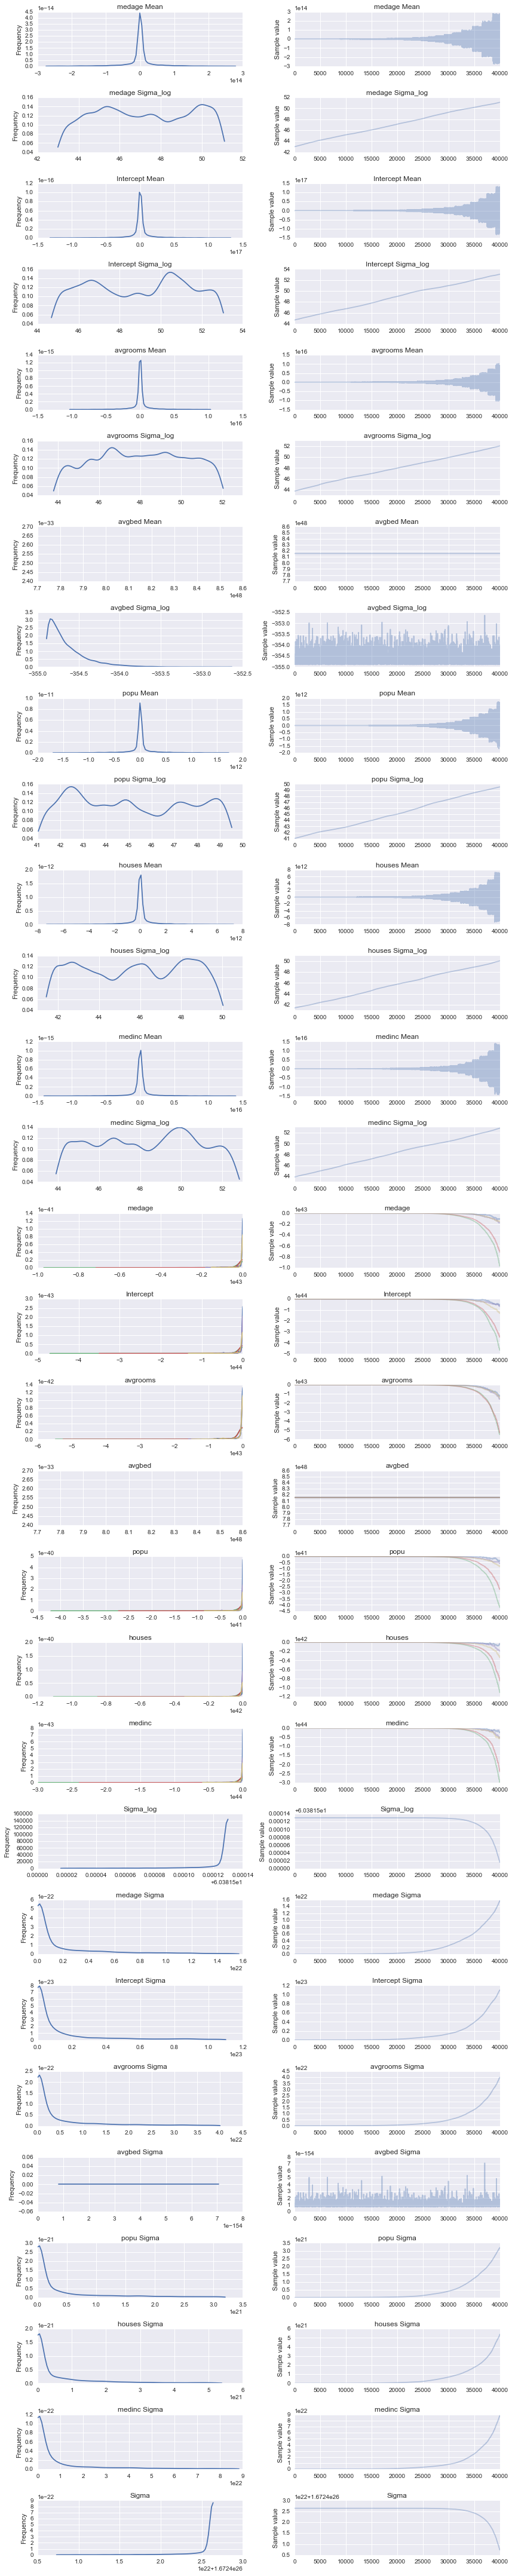

In [170]:
pm3.traceplot(trace_model[10000:]);

A Metropolis sampler is used because the NUTS sampler presented results from which the traceplots could not be created. The traceplots for the Metropolis sampler are clearly not convergent. If anything the values appear to diverge as the chain grows. This indicates something seriously wrong with the model. One possible reason is the strong correlation between the average number of rooms and average number of bedrooms variables. We will remove the bedrooms variable and retry the analysis.

In [11]:
hier_model_regions = pm3.Model()

with hier_model_regions:
    # hierarchical parent variables
    mu_medage = pm3.Normal('medage Mean',mu = 1814.5090, sd=44.868)
    sigma_medage = pm3.HalfNormal('medage Sigma',sd = 20)
    mu_intercept = pm3.Normal('Intercept Mean',mu = -5.277e+04, sd=2663.075)
    sigma_intercept = pm3.HalfNormal('Intercept Sigma',sd = 20)
    mu_avgrooms = pm3.Normal('avgrooms Mean',mu = -1.73e+04, sd=586.027)
    sigma_avgrooms = pm3.HalfNormal('avgrooms Sigma',sd = 20)
    mu_popu = pm3.Normal('popu Mean',mu = -39.5951, sd=1.112)
    sigma_popu = pm3.HalfNormal('popu Sigma',sd = 20)
    mu_houses = pm3.Normal('houses Mean',mu = 137.5185, sd=3.321)
    sigma_houses = pm3.HalfNormal('houses Sigma',sd = 20)
    mu_medinc = pm3.Normal('medinc Mean',mu = 5.163e+04, sd=399.988)
    sigma_medinc = pm3.HalfNormal('medinc Sigma',sd = 20)
    
    # Non-Hierarchical Parameters
    medage = pm3.Normal('medage',mu = mu_medage, sd=sigma_medage,shape=regions)
    intercept = pm3.Normal('Intercept',mu = mu_intercept, sd=sigma_intercept,shape=regions)
    avgrooms = pm3.Normal('avgrooms',mu = mu_avgrooms, sd=sigma_avgrooms,shape=regions)
    popu = pm3.Normal('popu',mu = mu_popu, sd=sigma_popu,shape=regions)
    houses = pm3.Normal('houses',mu = mu_houses, sd=sigma_houses,shape=regions)
    medinc = pm3.Normal('medinc',mu = mu_medinc, sd=sigma_medinc,shape=regions)
    sigma = pm3.HalfNormal('Sigma',sd = 20)
    
    mu = intercept[label] + medage[label]*data.medage + avgrooms[label]*data.avgrooms +\
        popu[label]*data.popu + houses[label]*data.houses + \
        medinc[label]*data.medinc
        
    like = pm3.Normal('Likelihood',mu=mu,sd=sigma,observed=data.medhv)

Applied log-transform to medage Sigma and added transformed medage Sigma_log to model.
Applied log-transform to Intercept Sigma and added transformed Intercept Sigma_log to model.
Applied log-transform to avgrooms Sigma and added transformed avgrooms Sigma_log to model.
Applied log-transform to popu Sigma and added transformed popu Sigma_log to model.
Applied log-transform to houses Sigma and added transformed houses Sigma_log to model.
Applied log-transform to medinc Sigma and added transformed medinc Sigma_log to model.
Applied log-transform to Sigma and added transformed Sigma_log to model.


In [ ]:
with hier_model_regions:
    step = pm3.Metropolis()
    trace_model = pm3.sample(50000, step)

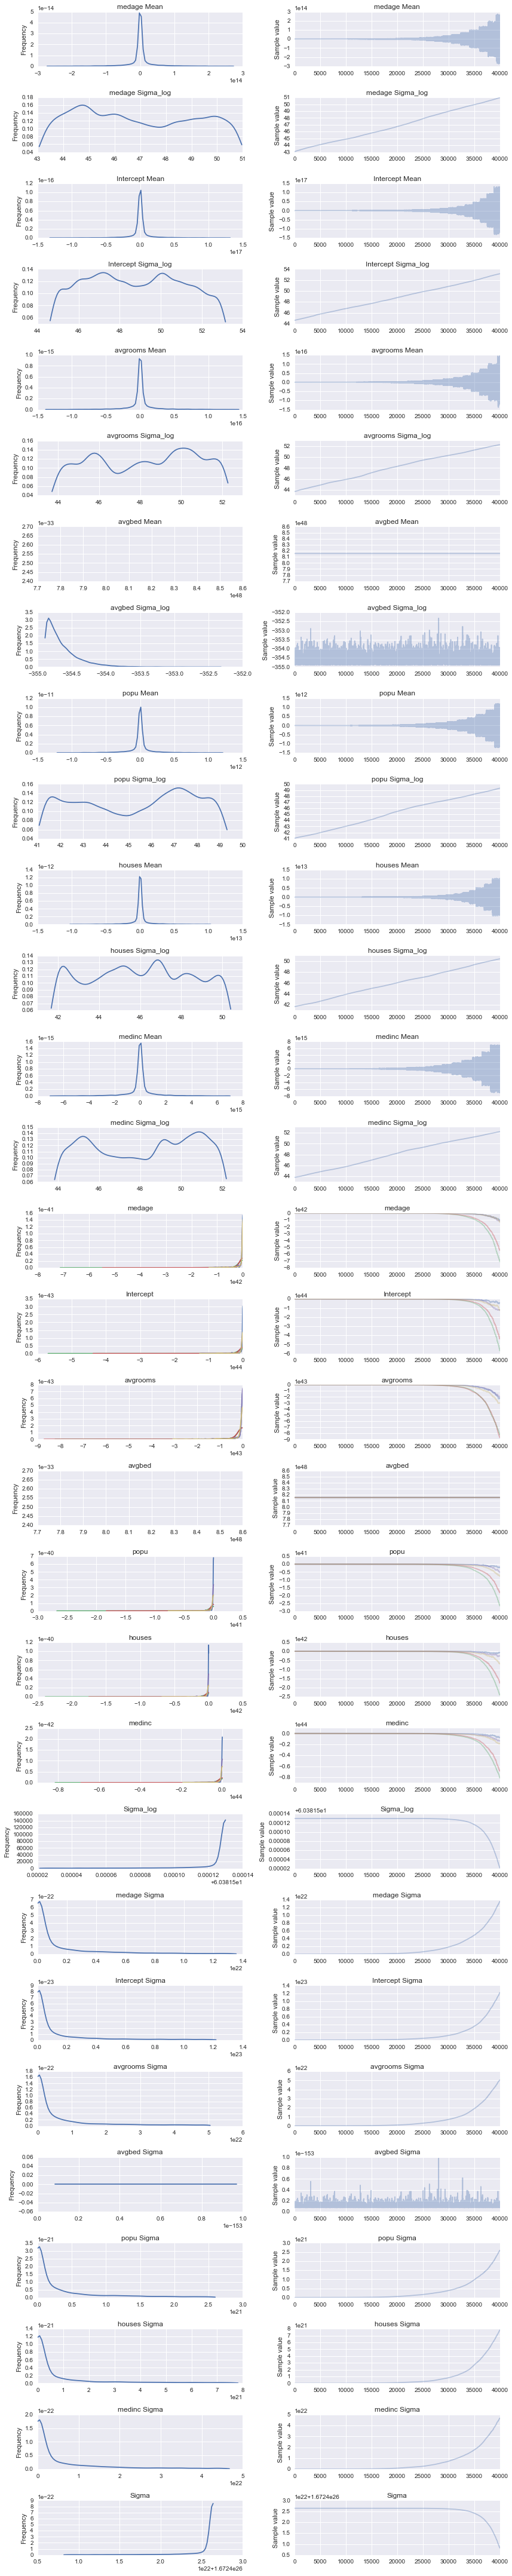

In [180]:
pm3.traceplot(trace_model[10000:]);

The output of the model shows us many results that we would have expected. Perhaps one surprising results is the generally negative effect of higher population on home values across the regions. This could be indicative of lower home prices in density populated inner city areas. We also see a great deal of variation across the regions, in some cases leading to sign changes in the expected effect of parameters. This indicates that the regional clusters do in turn reflect a genuine underlying difference in home markets.

While most of the distribtutions appear normally distributed and converged, one group (shown in purple) does not appear converged. It has a much broader distribution than other regions. In this case there may be some differences within that region that the model is not picking up. One area for exploration could be to look at rural vs urban census blocks as this might explain the wide variation within that region. 

This data also seems ripe for a spatial analysis. This would require a great deal of data munging to create an adajacency matrix but it seems entirely possible that there may be interaction between adjacent area with regards to home price, i.e run down areas may lower home values in surrounding areas.